# XGBoost regression to predict severity of insurance claims

## Obtain the data

In [1]:
# Read the training and testing CSV files into dataframes
import pandas as pd
train_csv=pd.read_csv('train.csv')
test_csv=pd.read_csv('test.csv')

## Prepare the data for exploration and visualization

In [2]:
#Separate the loss column from the training data
loss=train_csv.iloc[:,train_csv.shape[1]-1]
loss=pd.DataFrame({'loss':loss})
train_csv=train_csv.drop(labels=['loss'],axis=1)

In [3]:
#Remove id column from both dataframes but save the IDs of testing data
#Because it doesn't aid in training process
train_csv=train_csv.iloc[:,1:]
ID=test_csv['id']
test_csv=test_csv.iloc[:,1:]

## Visualize and transform the continuous features

### Visualization

In [4]:
#Get the continuous variables so as to aid visualization
split=116
cont_data=train_csv.iloc[:,split:]
cont_col_names=cont_data.columns
print("Number of continuous features: "+str(cont_data.shape[1]))

Number of continuous features: 14


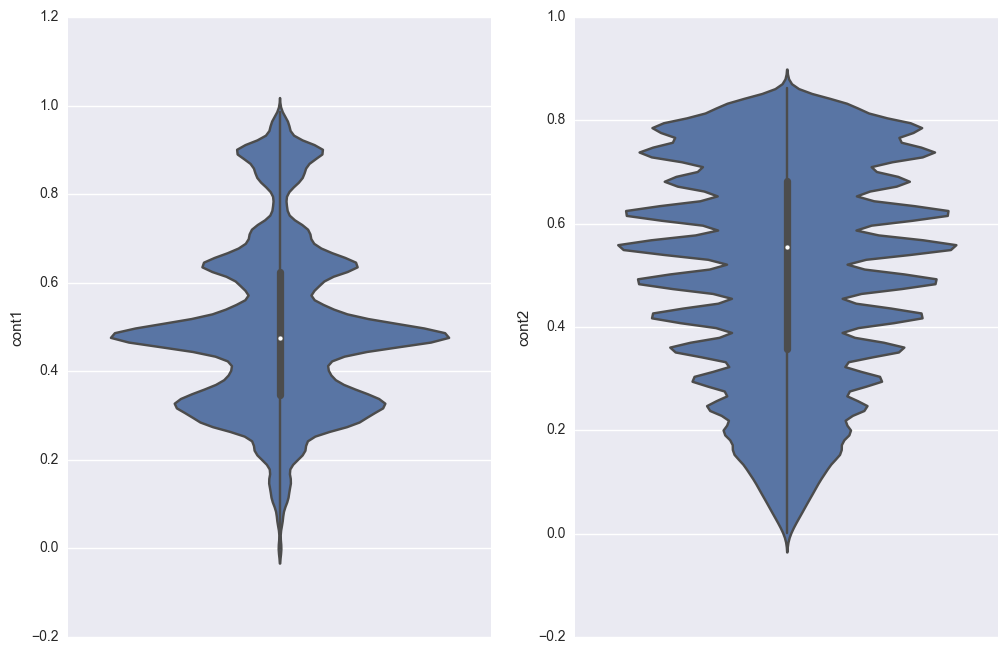

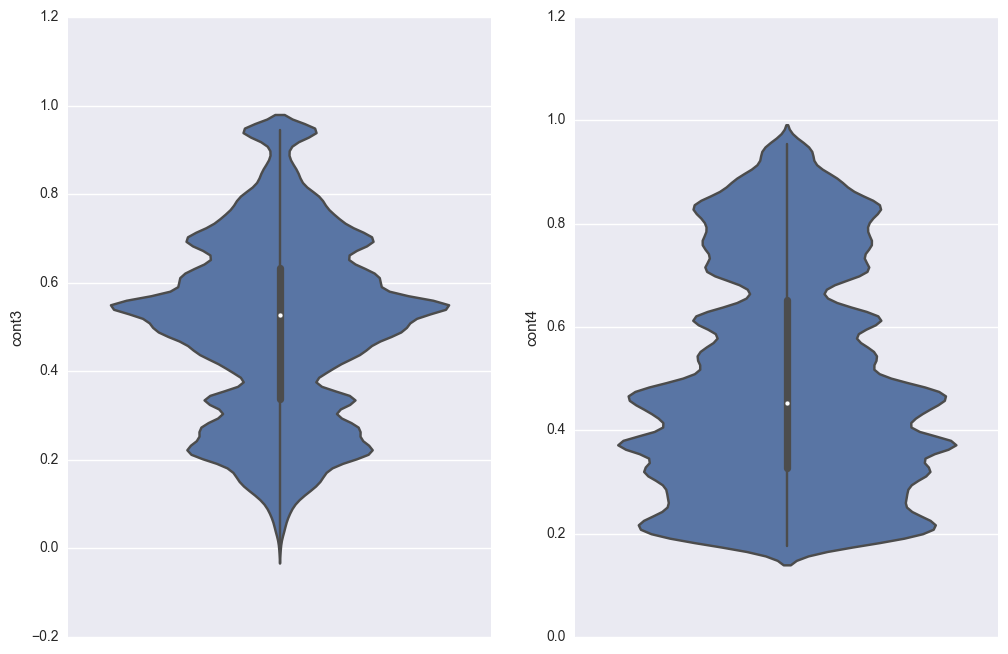

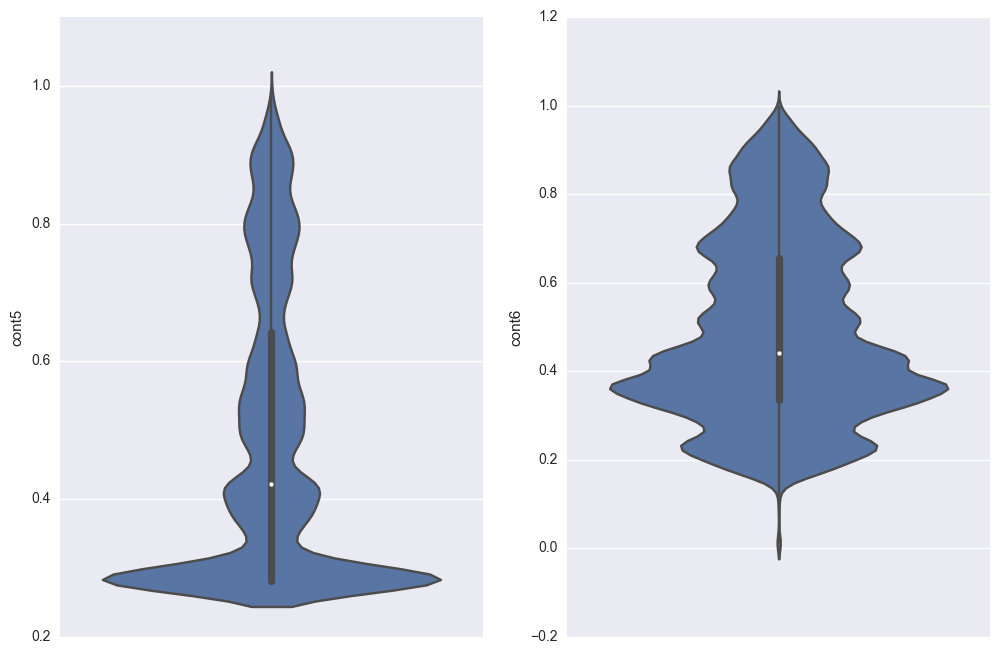

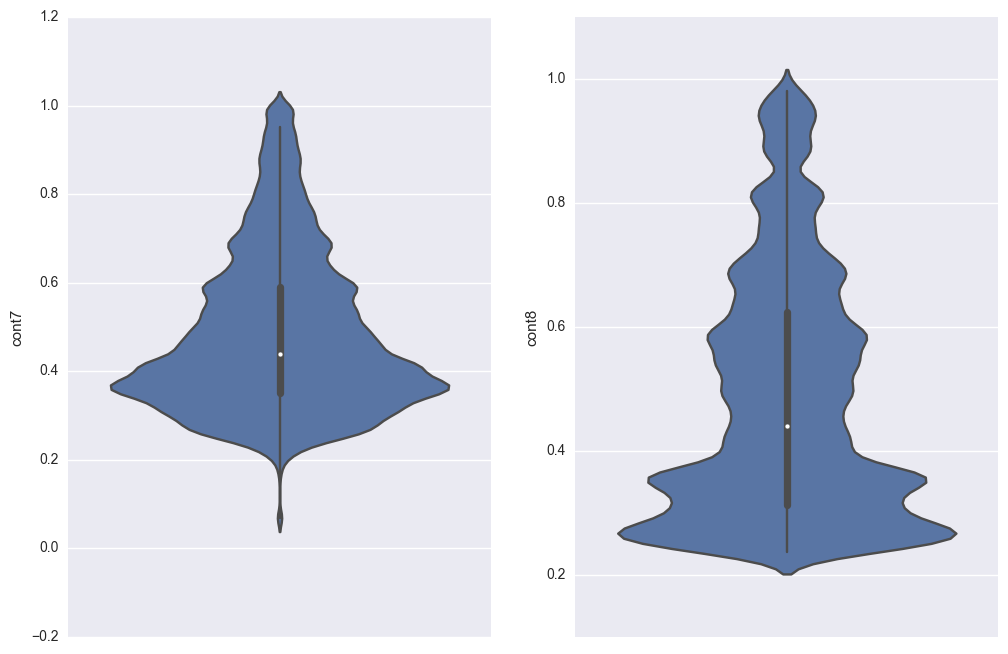

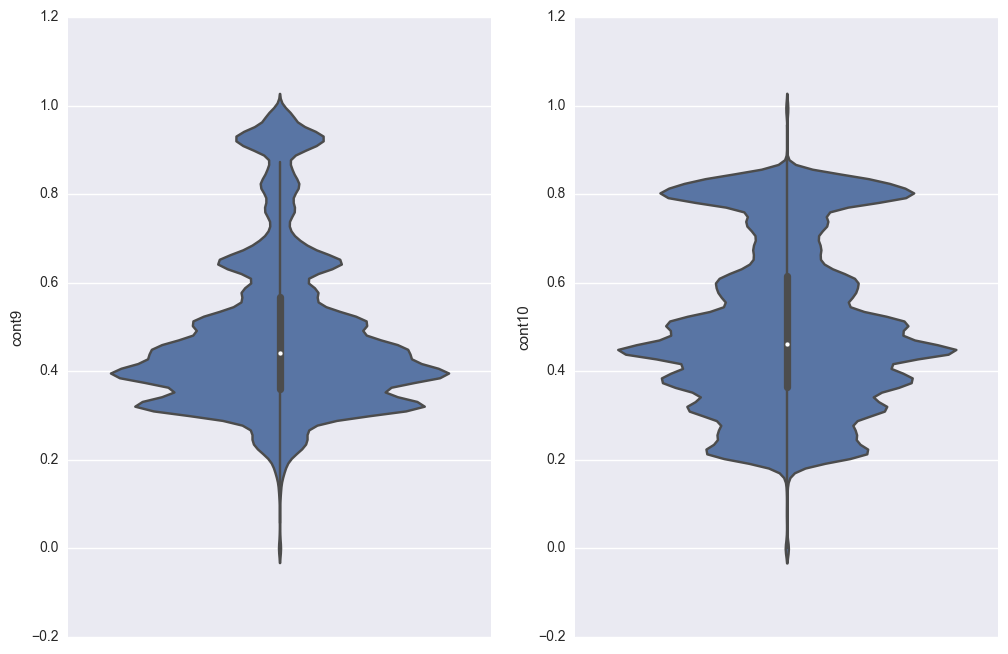

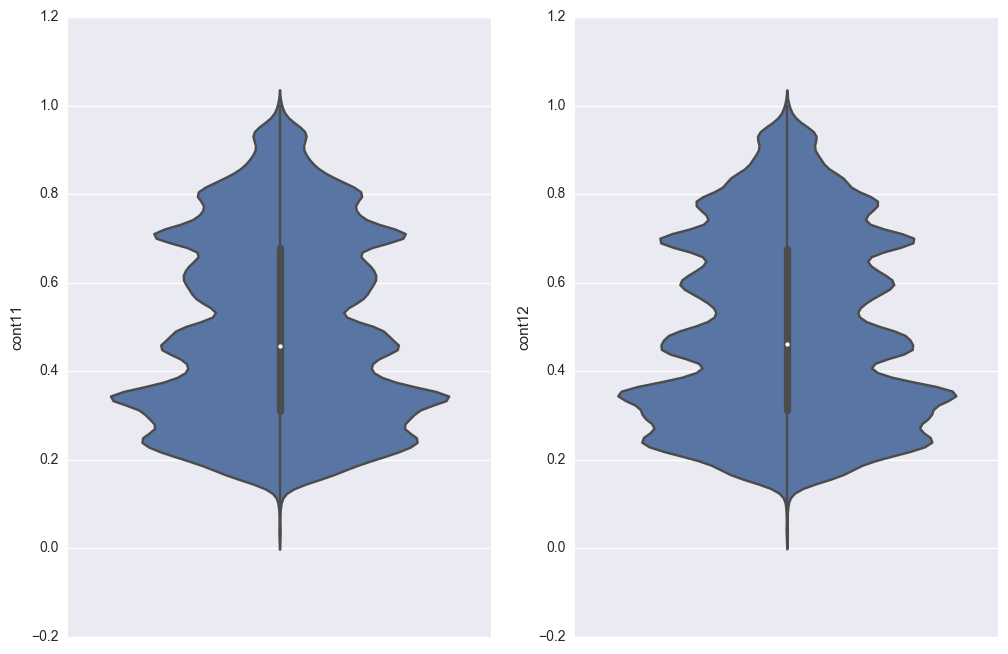

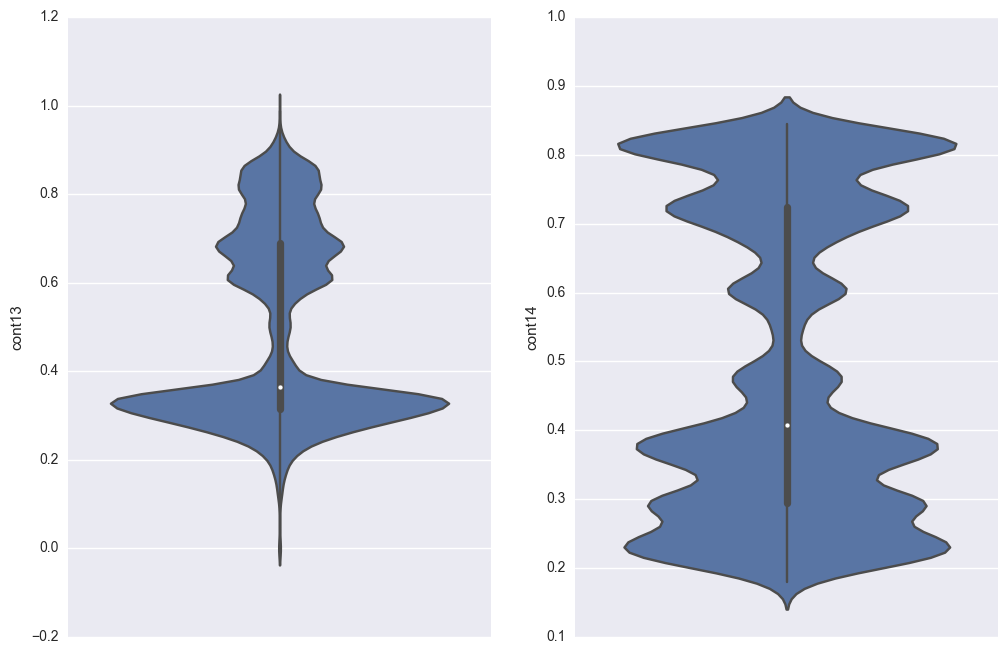

In [5]:
#Visualize the continuous data using violin plots from seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
n_cols=2
n_rows=7
for i in range(n_rows):
    fg,ax=plt.subplots(nrows=1,ncols=n_cols,figsize=(12,8))
    for j in range(n_cols):
        sns.violinplot(y=cont_col_names[i*n_cols+j],data=train_csv,ax=ax[j])
plt.show()

The figures show that some continuous features are skewed.

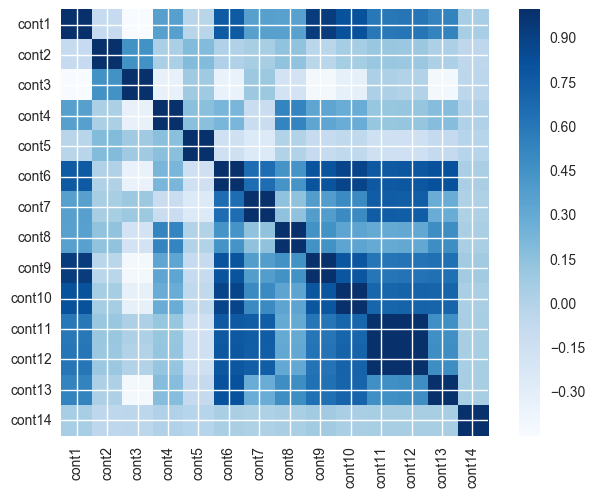

In [6]:
#Look at correlation between continuous varaibles
plt.imshow(cont_data.corr(),cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
tick_marks=[i for i in range(len(cont_data.columns))]
plt.xticks(tick_marks,cont_data.columns,rotation='vertical')
plt.yticks(tick_marks,cont_data.columns)
plt.show()

The correlation diagram shows that some features are correlated and thus can be eliminated using PC

### Exploration and tranformation

In [7]:
#Calculate the skew of continuous variables
from scipy.stats import skew
skewed_features=cont_data.apply(lambda x: skew(x))
print("skew in numerical features")
print(skewed_features)

skew in numerical features
cont1     0.516420
cont2    -0.310939
cont3    -0.010002
cont4     0.416093
cont5     0.681617
cont6     0.461211
cont7     0.826046
cont8     0.676629
cont9     1.072420
cont10    0.354998
cont11    0.280819
cont12    0.291990
cont13    0.380739
cont14    0.248672
dtype: float64


In [8]:
#Correct the skew everywhere
from scipy.stats import boxcox
skewed_features=skewed_features[skewed_features>0.25]
skewed_features=skewed_features.index
trainsplit=train_csv.shape[0]
train_test_combined=pd.concat((train_csv,test_csv)).reset_index(drop=True)
for feature in skewed_features:
    train_test_combined[feature]=train_test_combined[feature]+1
    train_test_combined[feature],lam=boxcox(train_test_combined[feature])
#Get back the training and testing dataframes with their continuous data unskewed and scaled
train_csv=train_test_combined.iloc[:trainsplit,:]
test_csv=train_test_combined.iloc[trainsplit:,:]

## Visualization and transformation of categorical features 

### Visualization

In [9]:
#Obtain categorical features
cat_data=train_csv.iloc[:,:split]
cat_col_names=cat_data.columns
print("Number of categorical features: "+str(cat_data.shape[1]))

Number of categorical features: 116


//anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


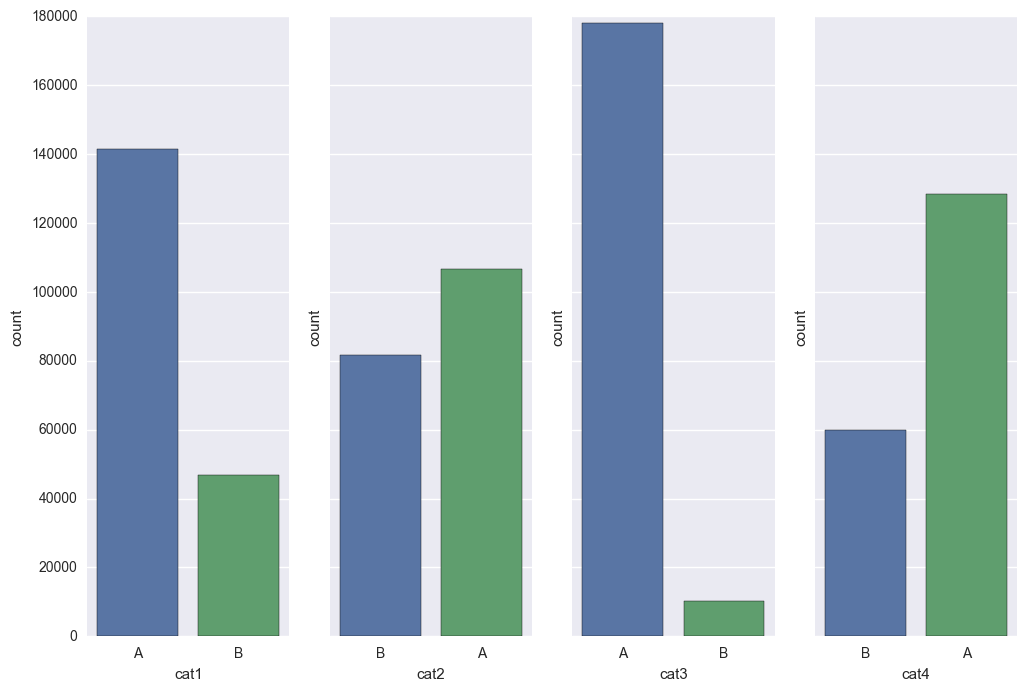

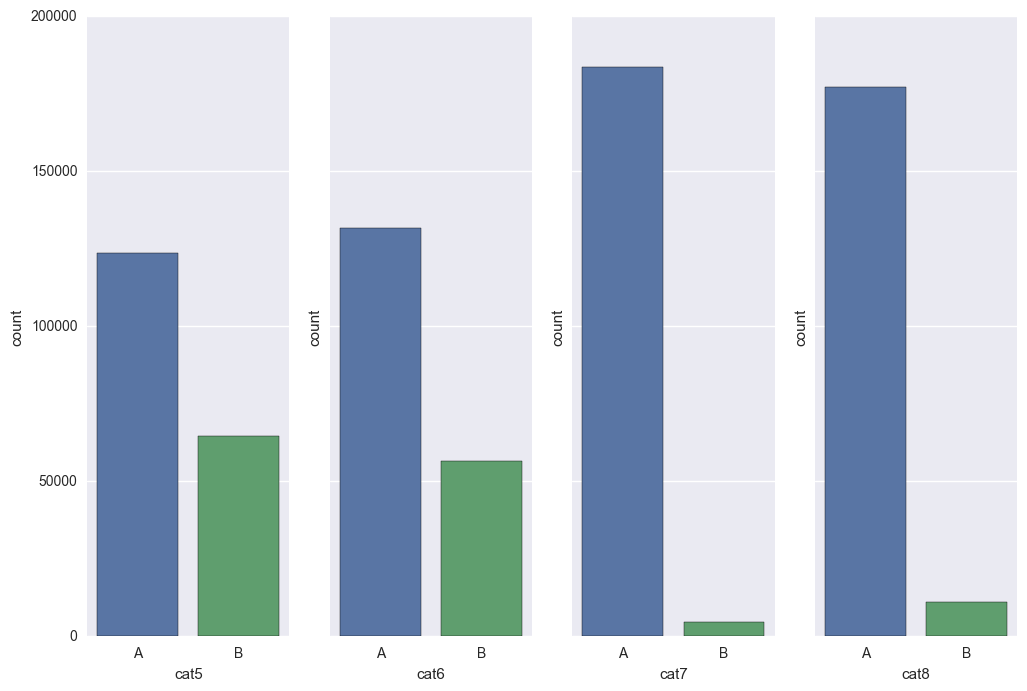

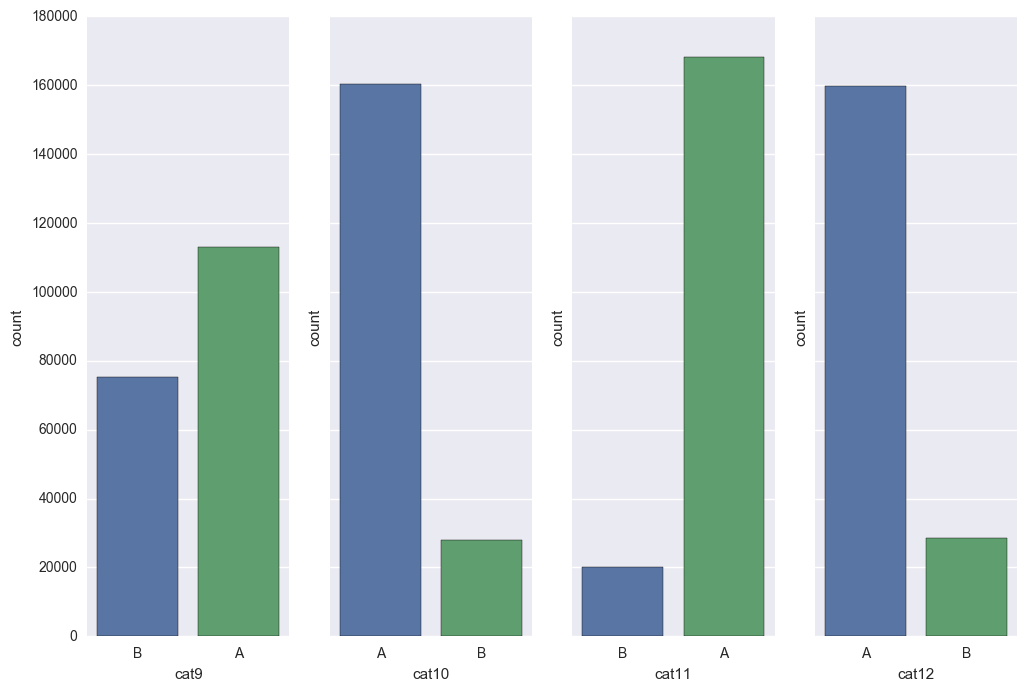

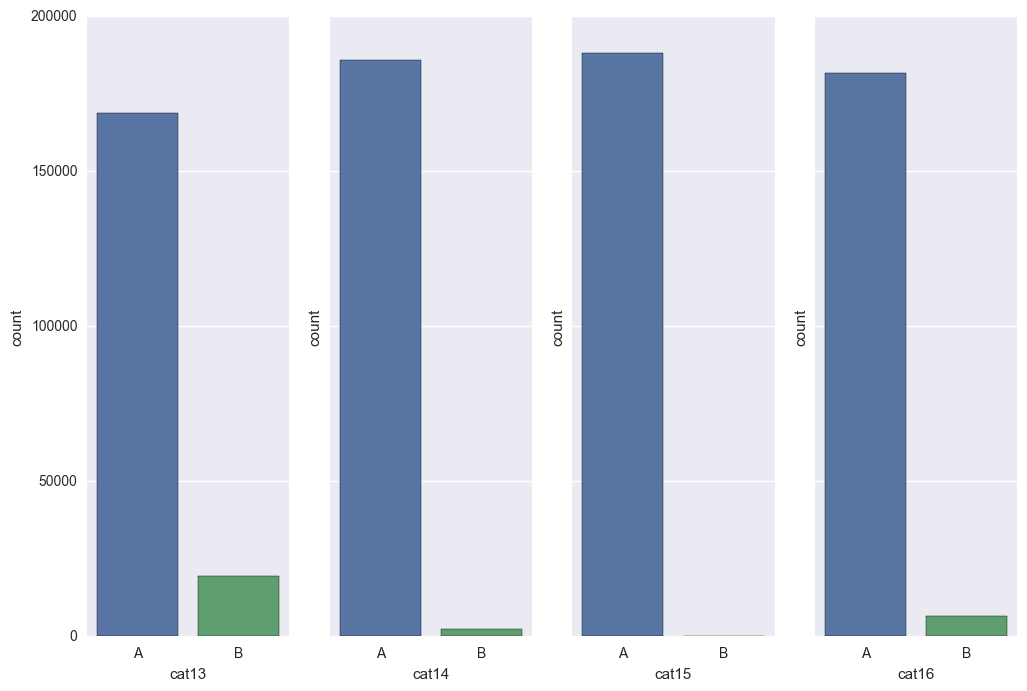

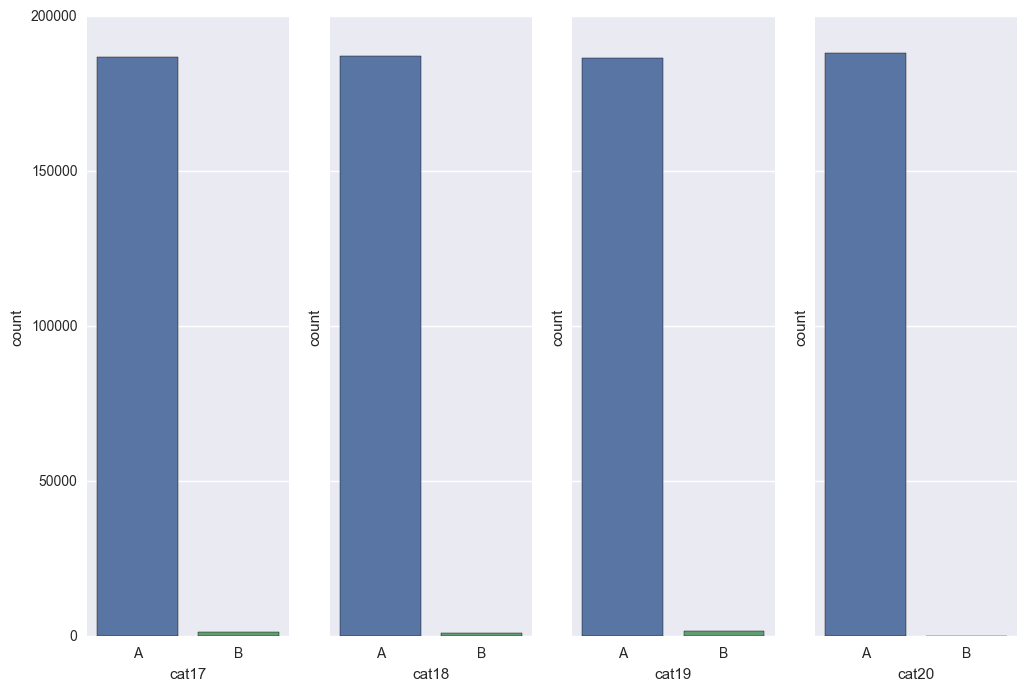

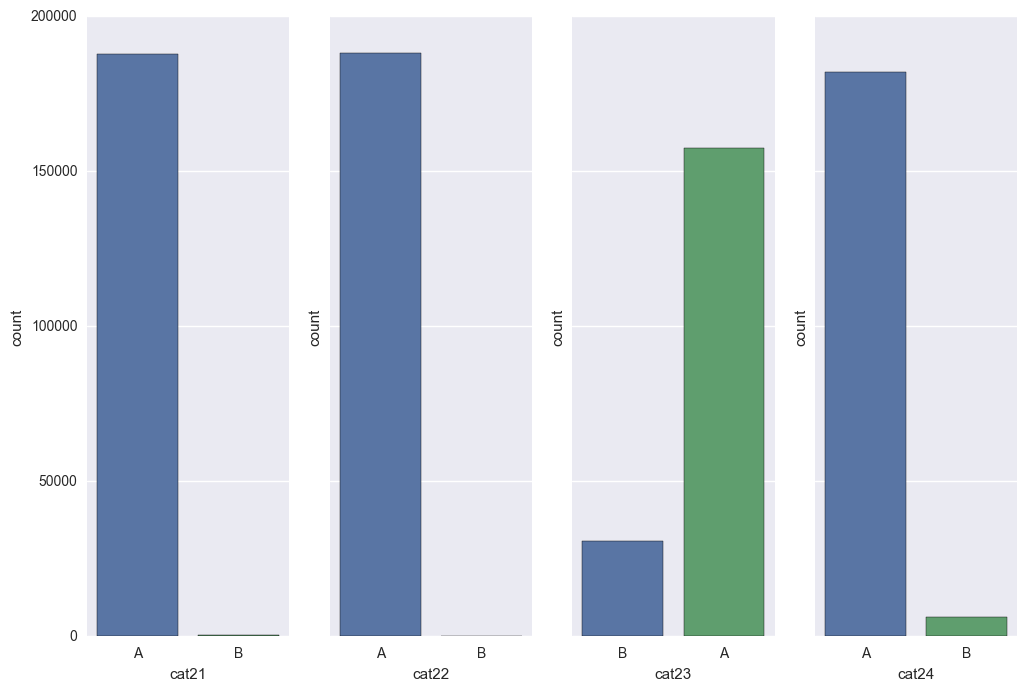

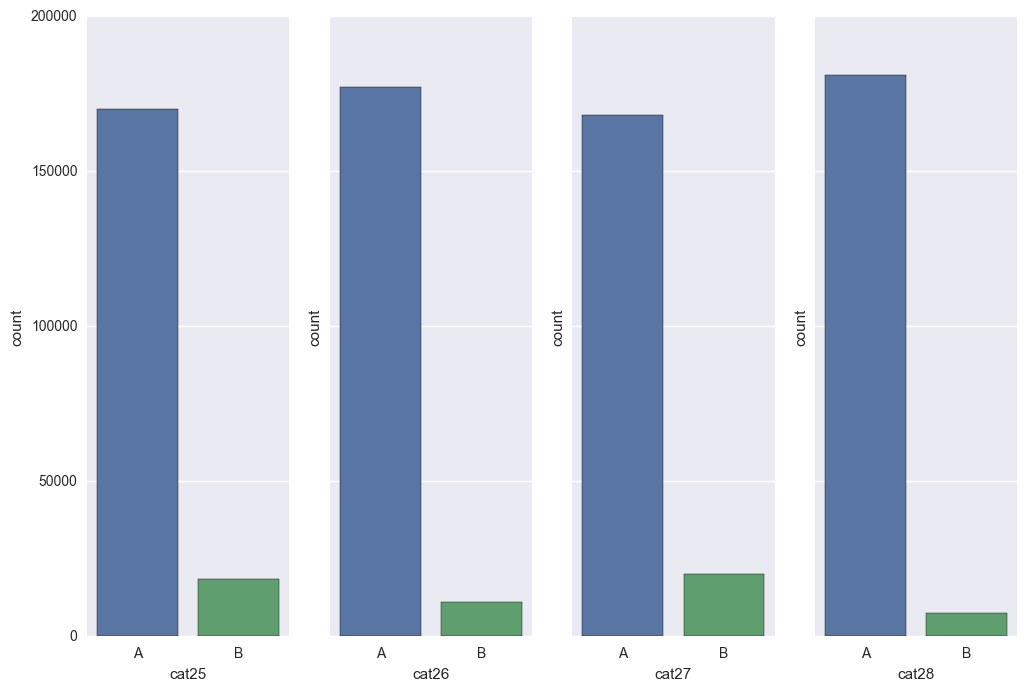

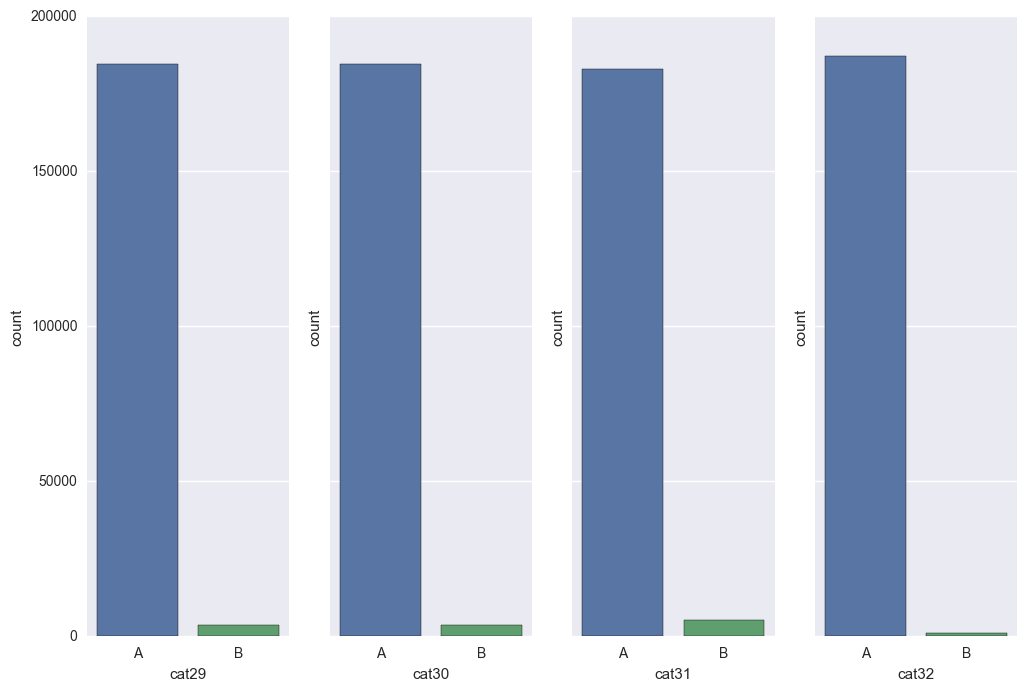

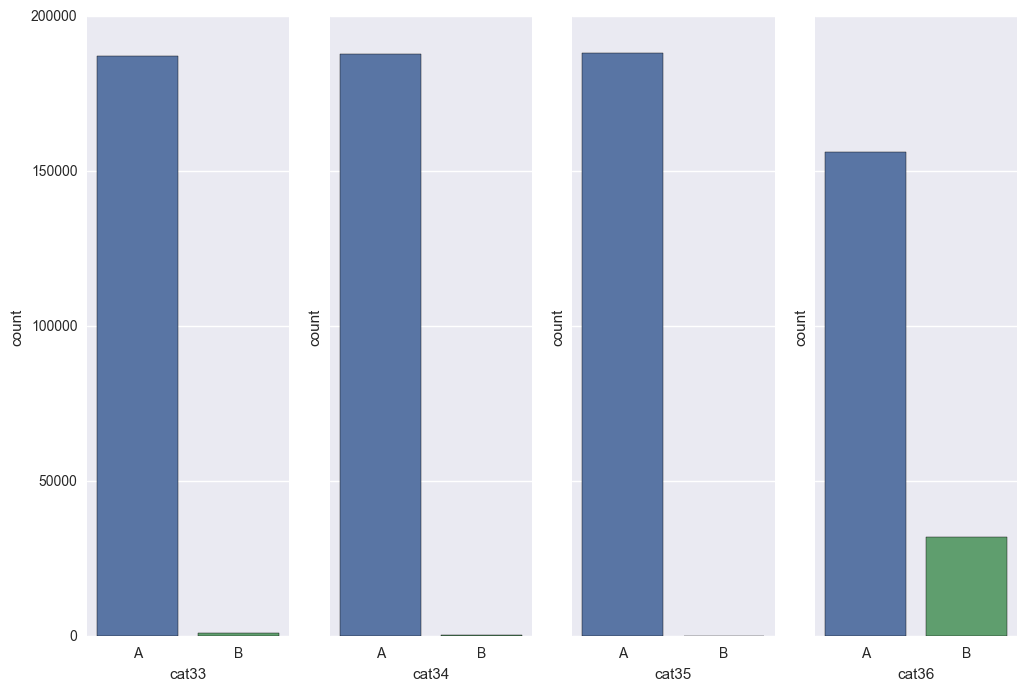

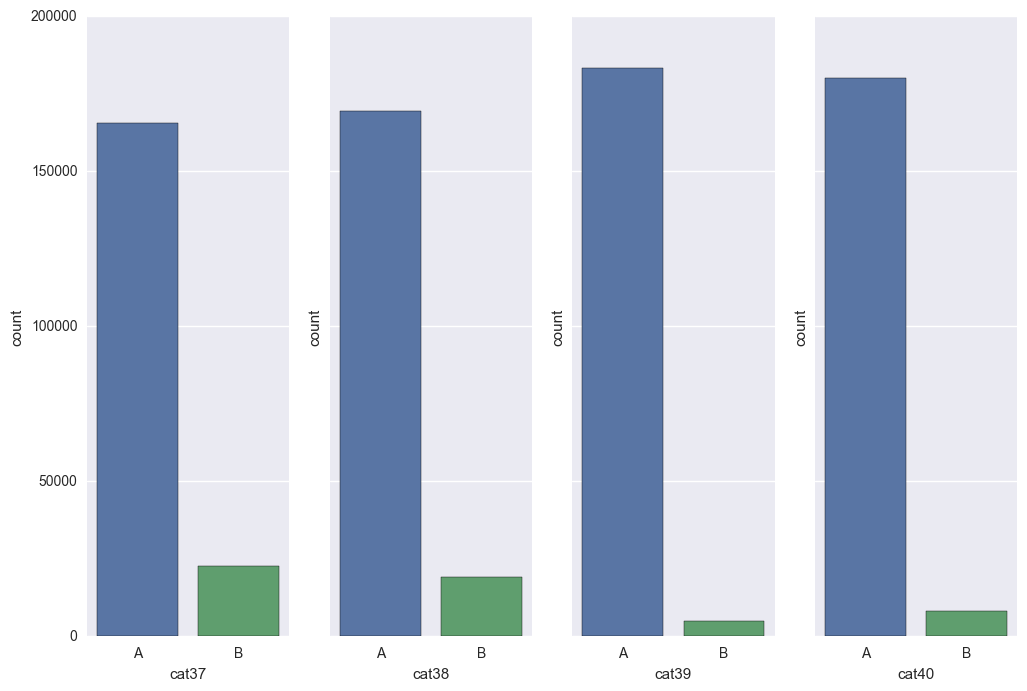

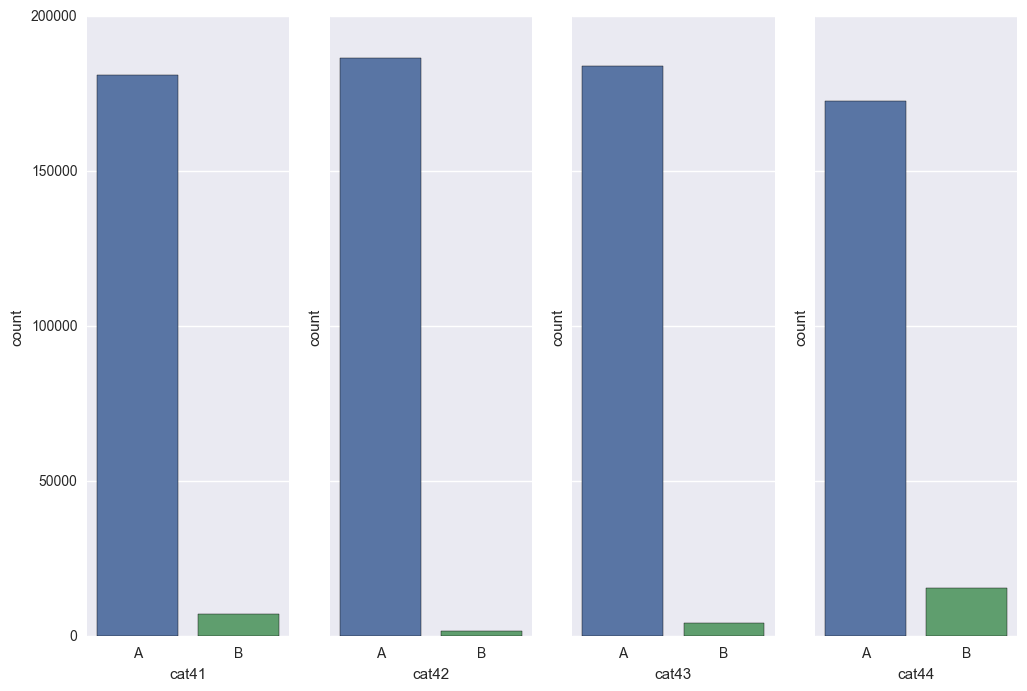

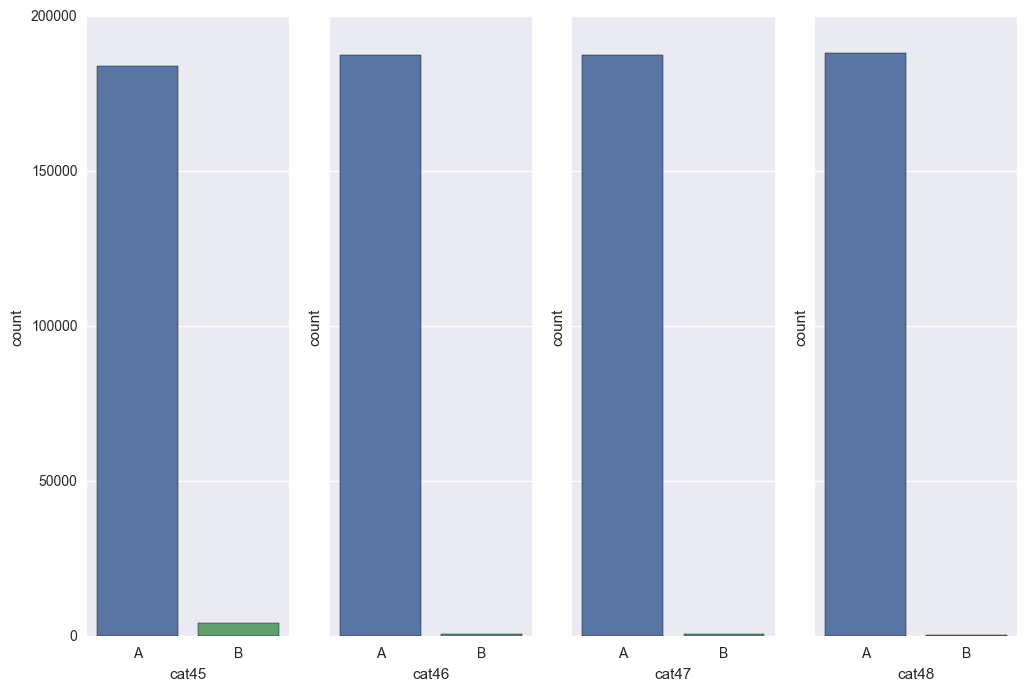

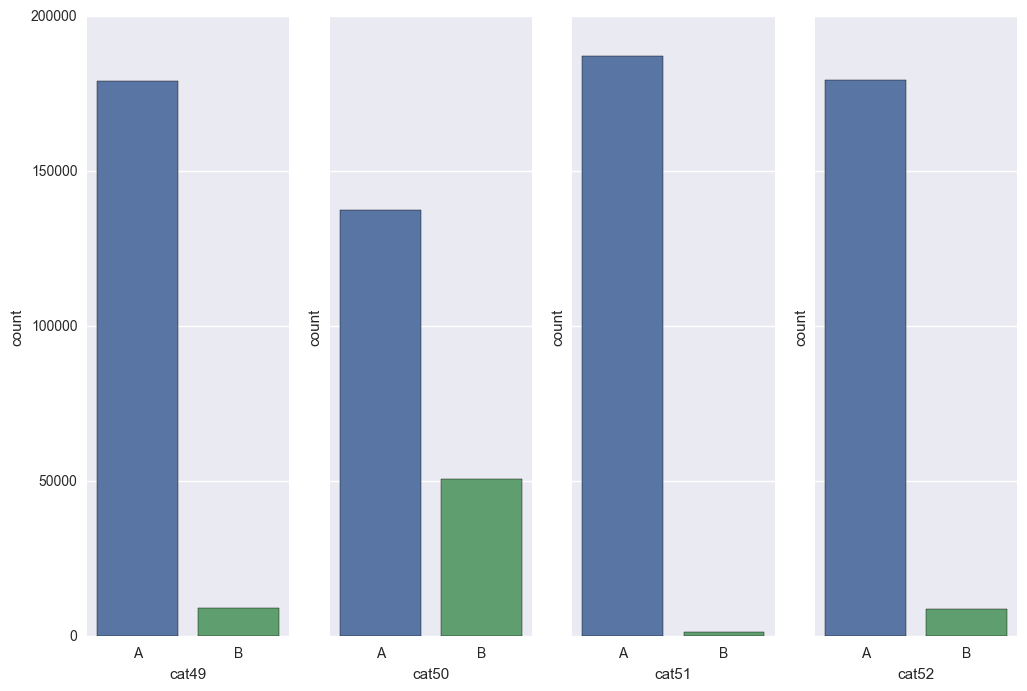

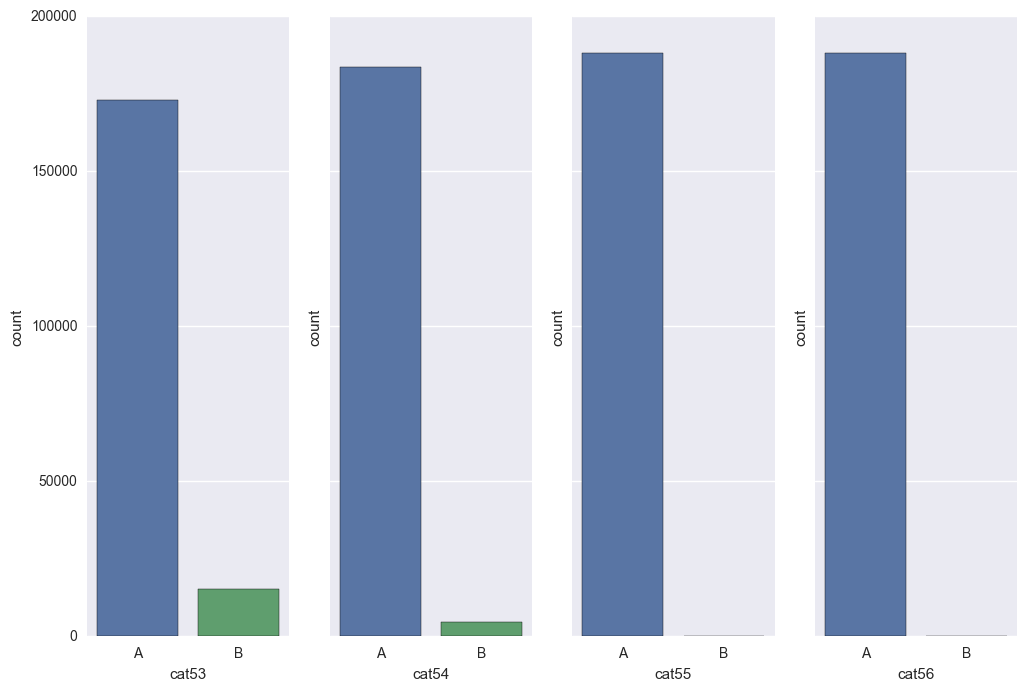

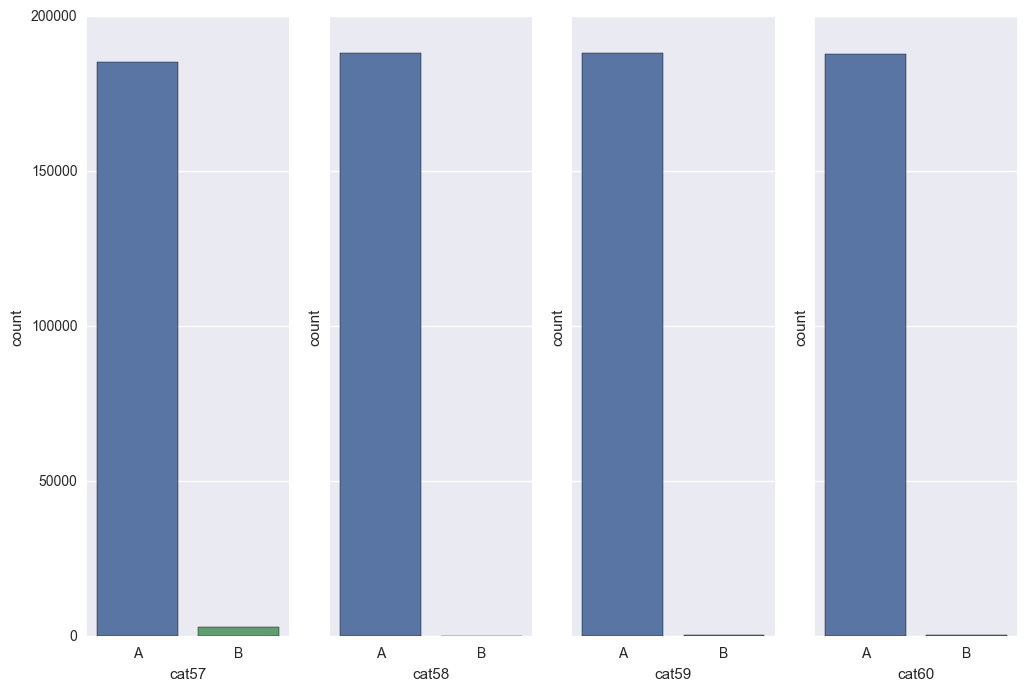

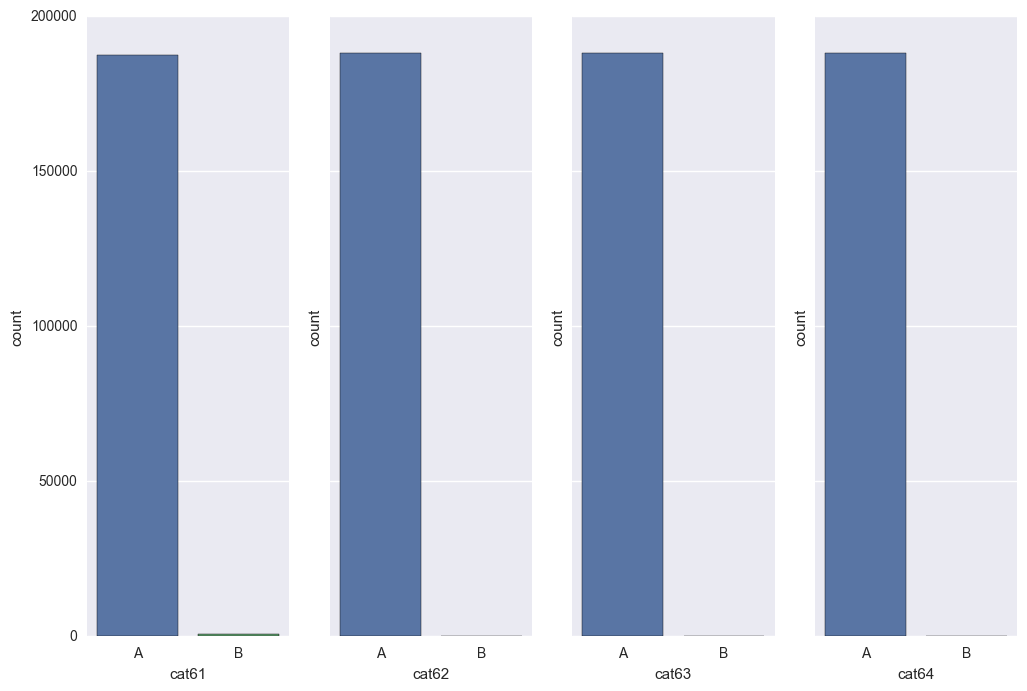

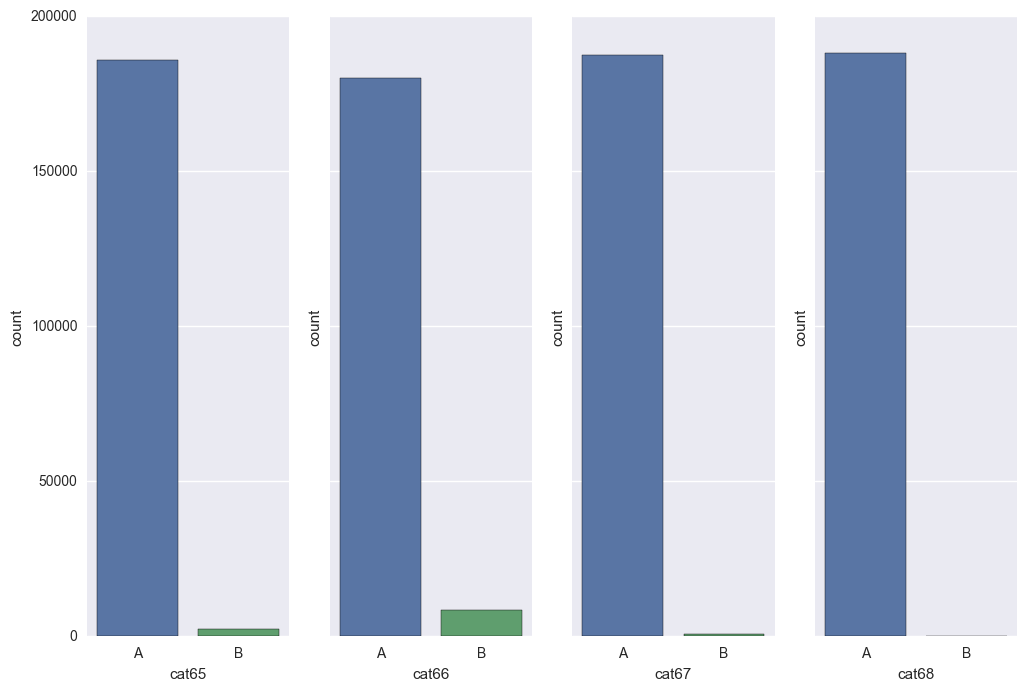

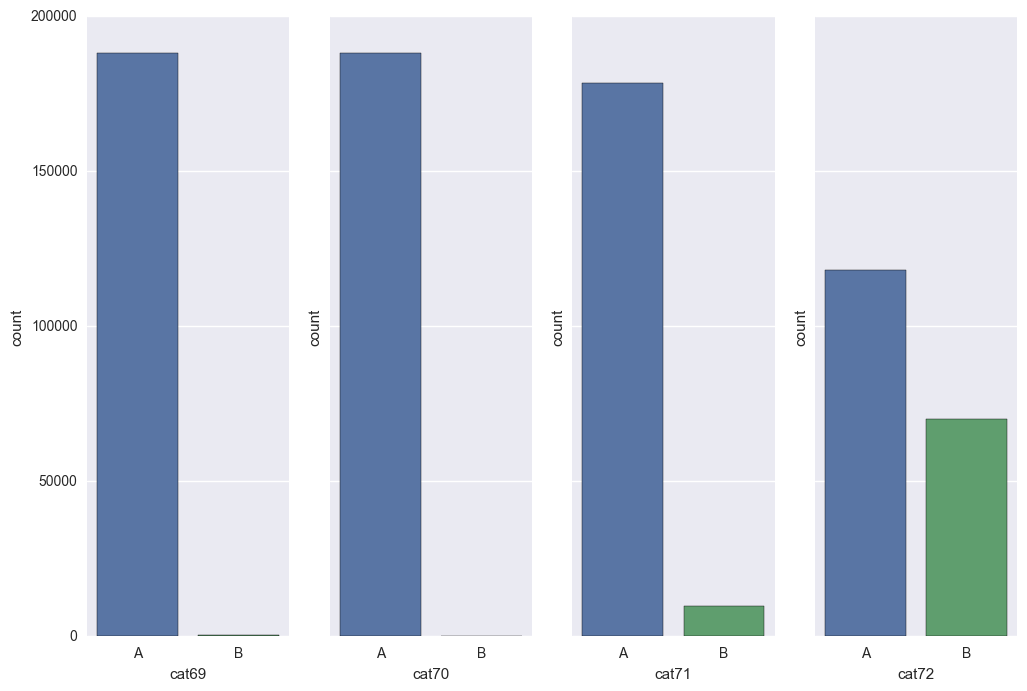

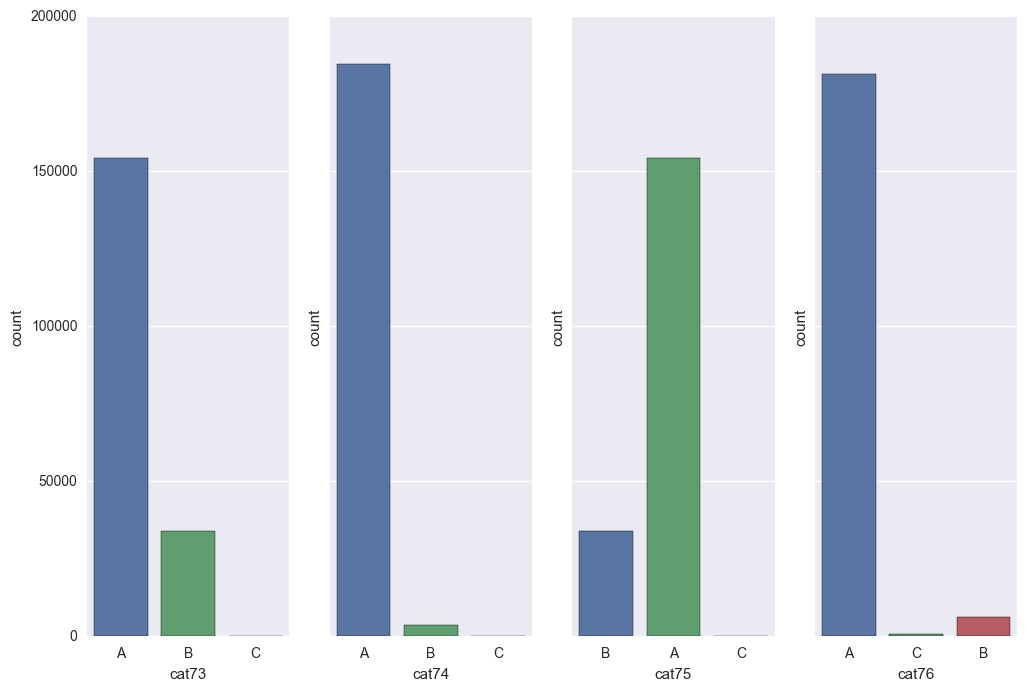

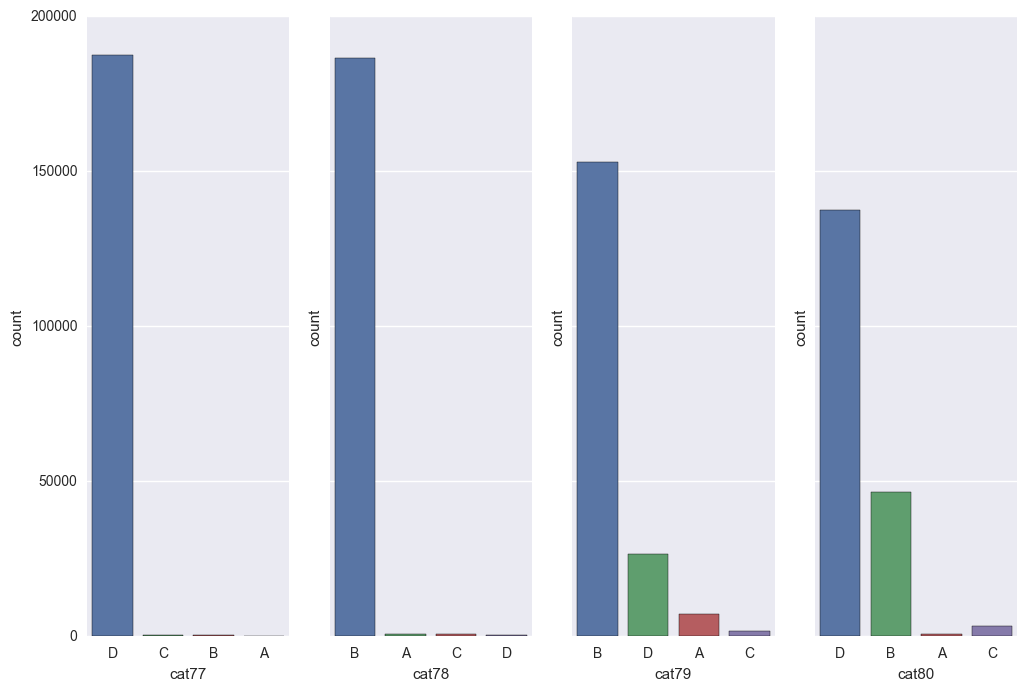

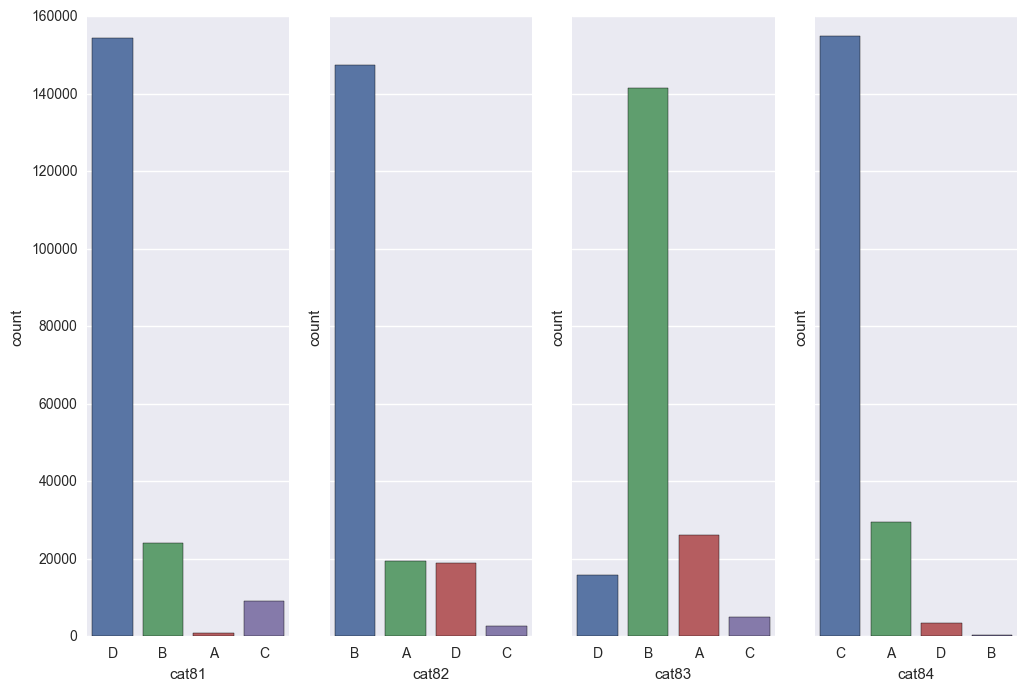

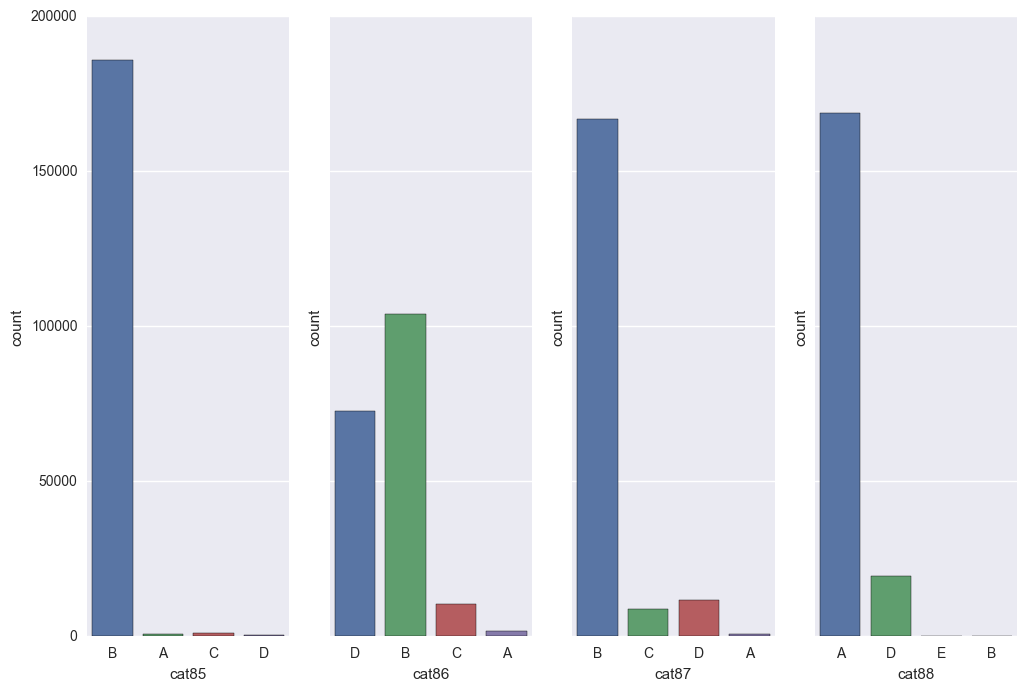

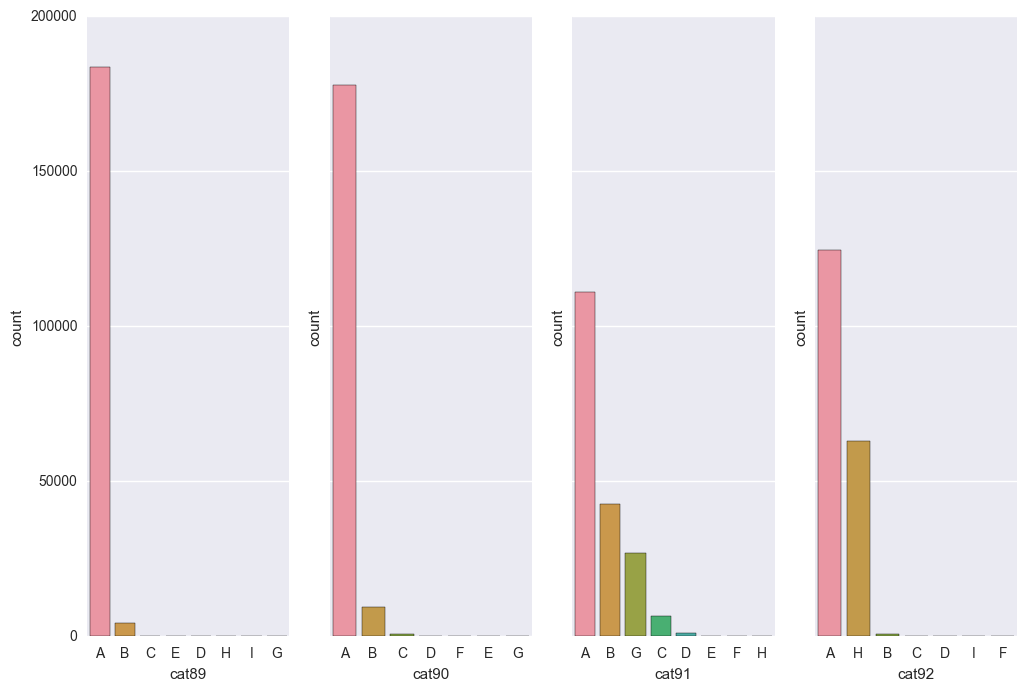

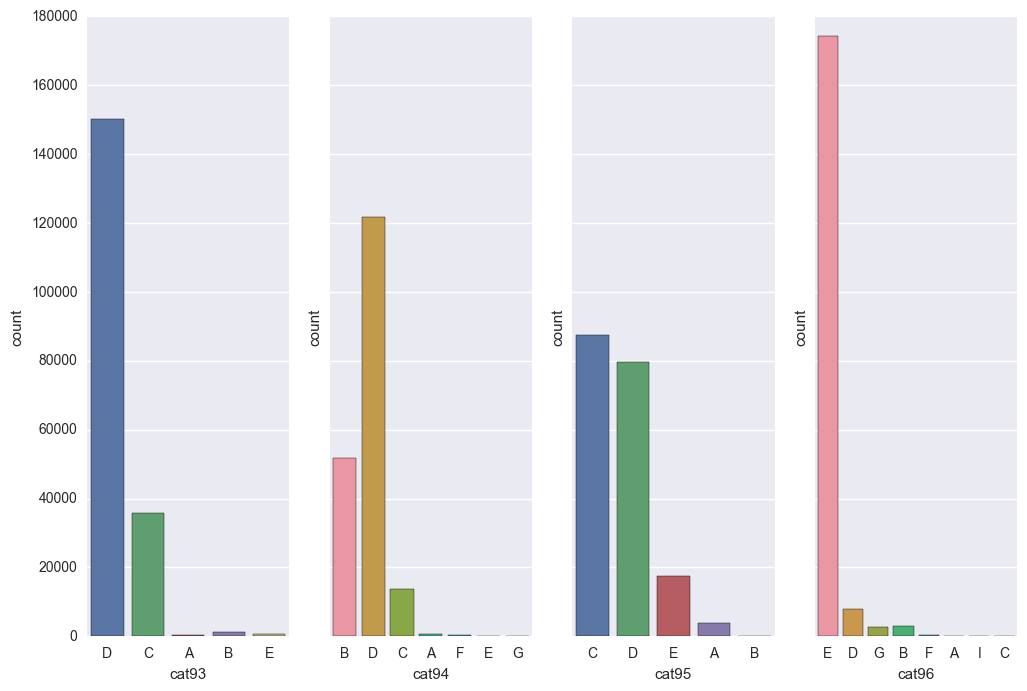

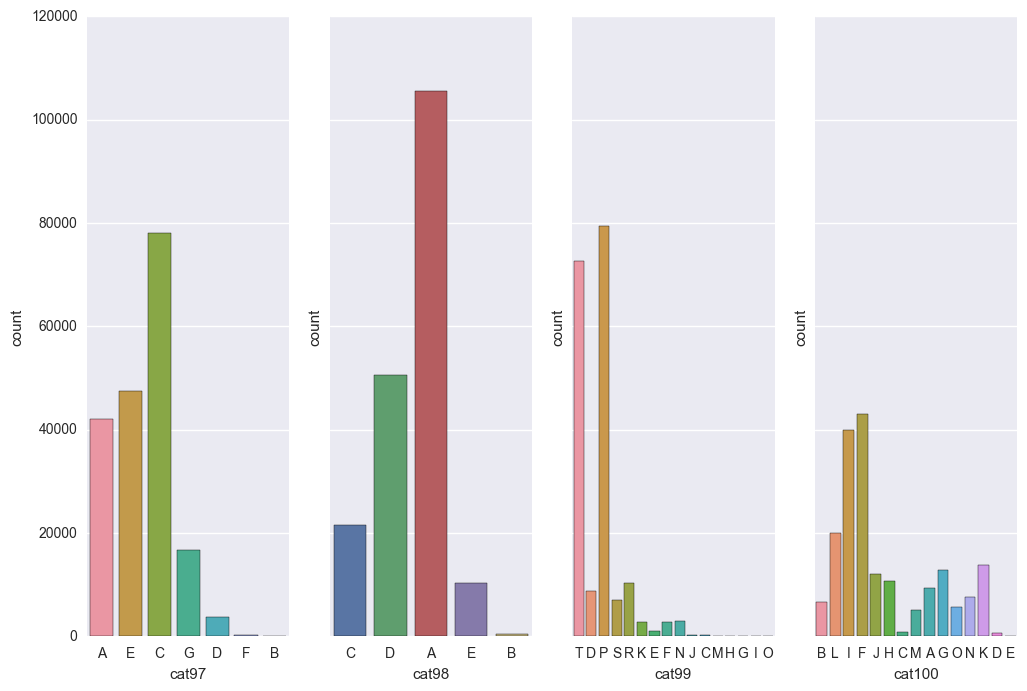

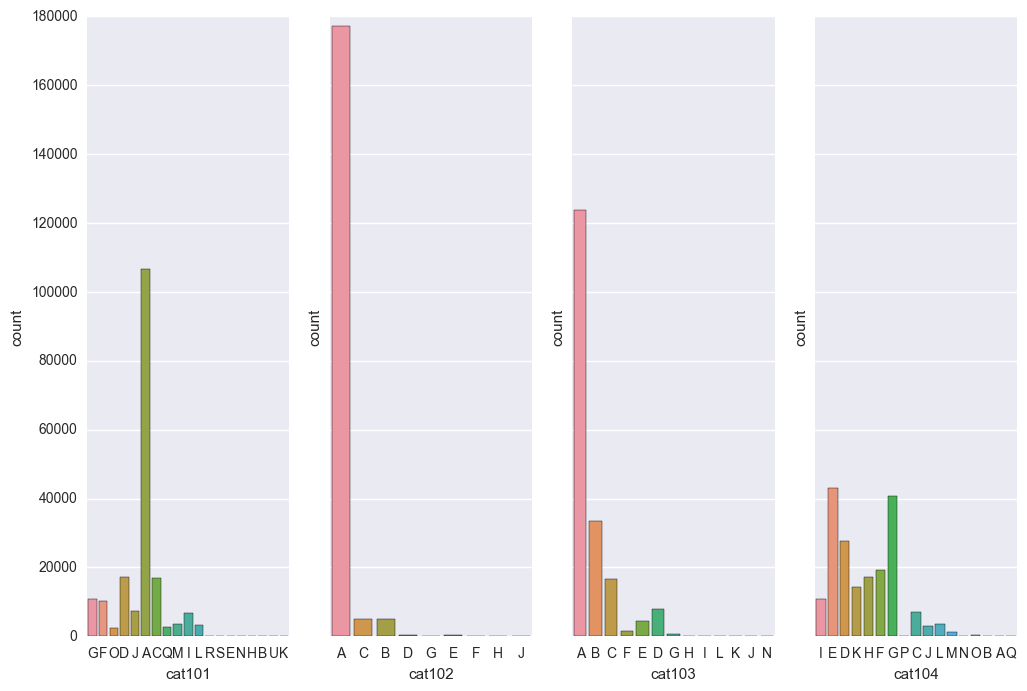

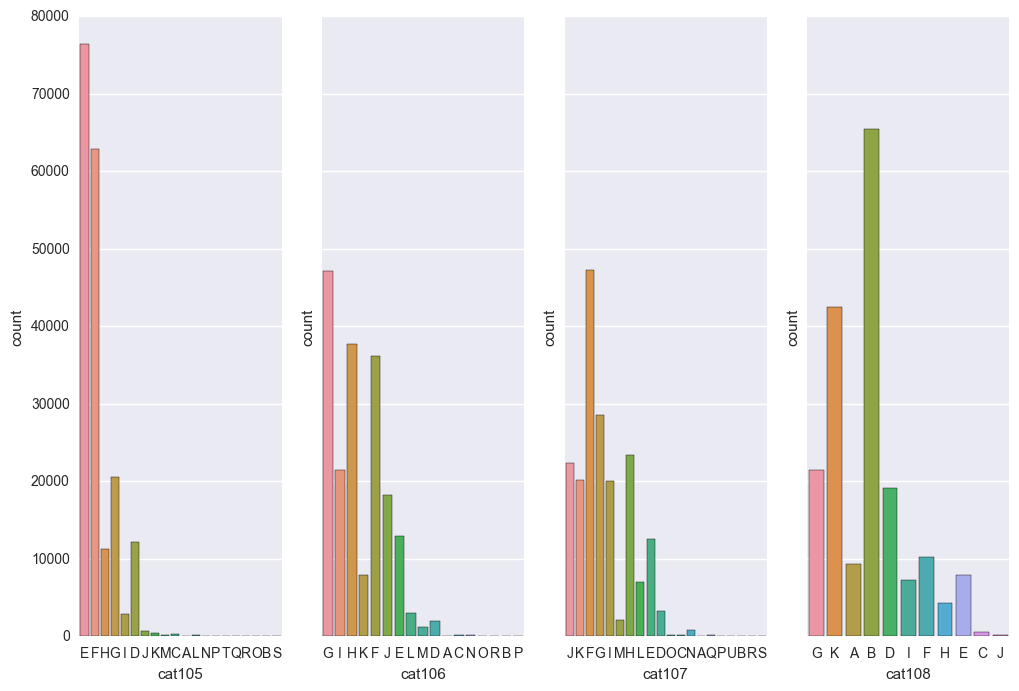

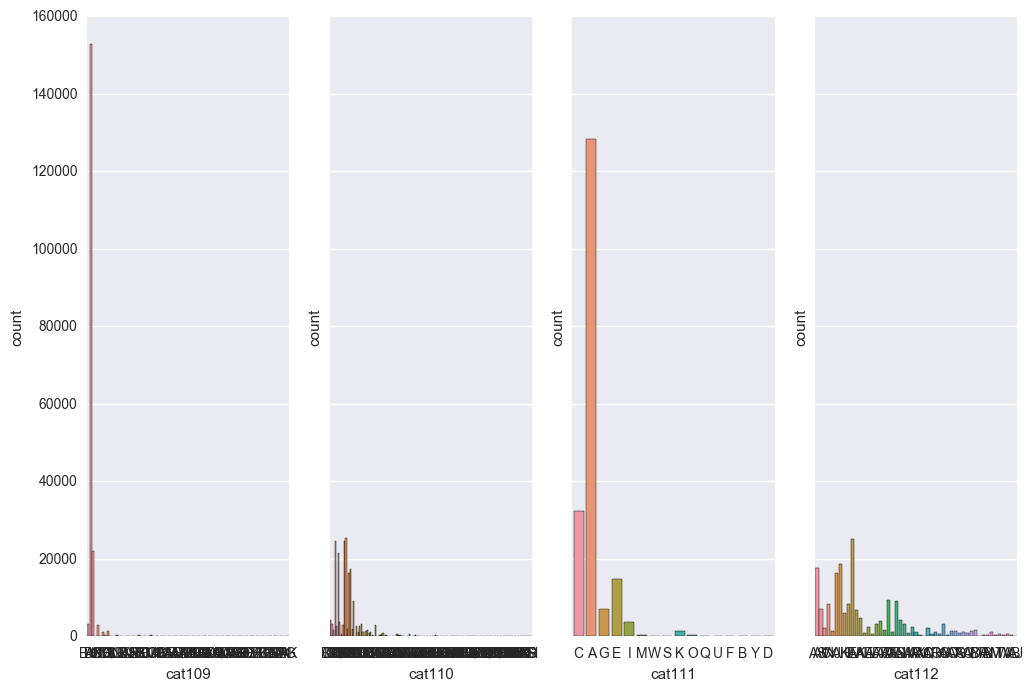

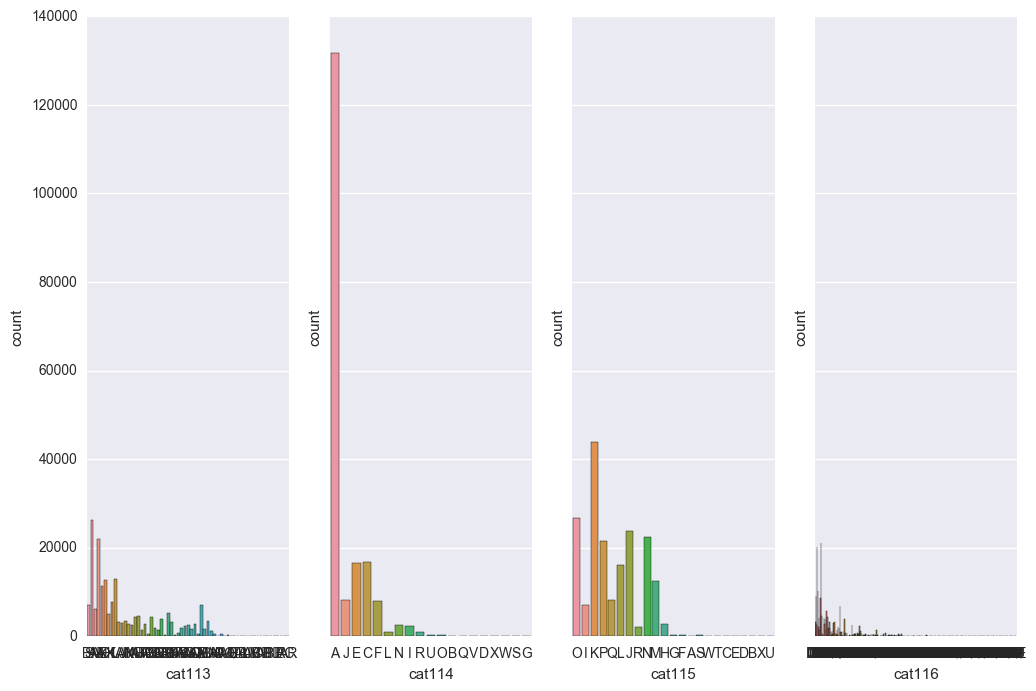

In [10]:
#Visualize them through histograms
n_rows=29
n_cols=4

for i in range(n_rows):
    fg,ax=plt.subplots(nrows=1,ncols=n_cols,sharey=True,figsize=(12,8))
    for j in range(n_cols):
        sns.countplot(x=cat_col_names[i*n_cols+j],data=cat_data,ax=ax[j])        
plt.show()

As the plots show some features do not provide much information and thus PCA will also be able to reduce the number of categorical features.

### One-hot encoding of categorical features

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
Labels=[]
for i in range(split):
    train=train_csv[cat_col_names[i]].unique()
    test=test_csv[cat_col_names[i]].unique()
    Labels.append(list(set(train) | set(test)))

#To store encoded features
train_cat=[]
test_cat=[]
    
for i in range(split):
    #Prepare the current categorical feature for OneHotEncoder which takes integers as input categories
    label_encoder=LabelEncoder()
    label_encoder.fit(Labels[i])
    train_feature=label_encoder.transform(train_csv.iloc[:,i])
    test_feature=label_encoder.transform(test_csv.iloc[:,i])
    train_feature=train_feature.reshape(train_csv.shape[0],1)
    test_feature=test_feature.reshape(test_csv.shape[0],1)
    #Use OneHotEncoder and append the newly generated features
    onehot_encoder=OneHotEncoder(sparse=False, n_values=len(Labels[i]))
    train_feature=onehot_encoder.fit_transform(train_feature)
    test_feature=onehot_encoder.fit_transform(test_feature)
    train_cat.append(train_feature)
    test_cat.append(test_feature)
    
#Convert cat from a list of 1D arrays to a 2D array
encoded_train_cats=np.column_stack(train_cat)
encoded_test_cats=np.column_stack(test_cat)

#Create new training dataset with the newly generated features
train_csv_encoded=np.concatenate((encoded_train_cats,train_csv.iloc[:,split:].values),axis=1)
train_df_encoded=pd.DataFrame(train_csv_encoded)
#Create new testing dataset with the newly generated features
test_csv_encoded=np.concatenate((encoded_test_cats,test_csv.iloc[:,split:].values),axis=1)
test_df_encoded=pd.DataFrame(test_csv_encoded)

## Visualize and transform labels

### Visualization

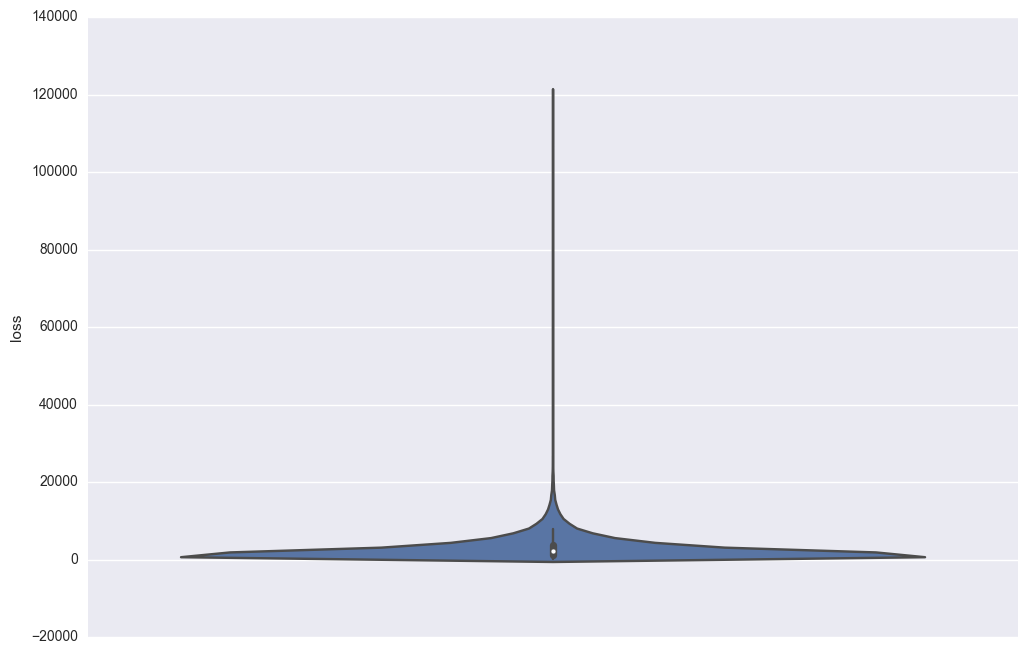

In [13]:
#Observe the skew of the loss column
fg,ax=plt.subplots(nrows=1,ncols=1,figsize=(12,8))
sns.violinplot(y='loss',data=loss,ax=ax)
plt.show()

As can be seen the label column is extremely skewed

### Transformation 

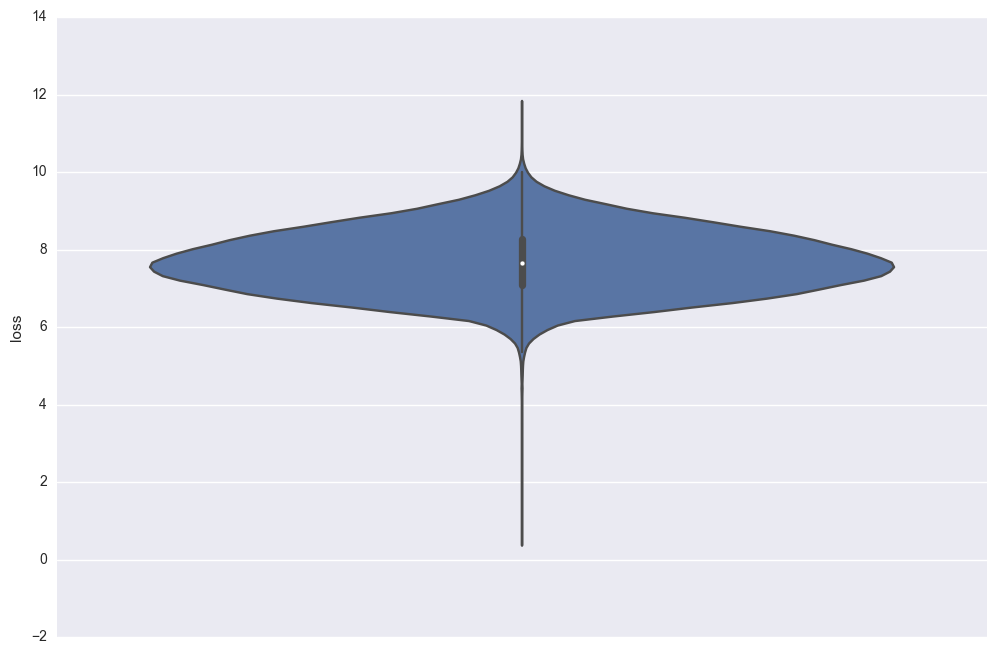

In [14]:
#Unskew the loss column
loss['loss']=np.log1p(loss['loss'])
fgi,axi=plt.subplots(nrows=1,ncols=1,figsize=(12,8))
sns.violinplot(y='loss',data=loss,ax=axi)
plt.show()

## Scaling of all features

In [16]:
#Scale the features in both training and testing dataframes
train_test=pd.concat((train_df_encoded,test_df_encoded)).reset_index(drop=True)

from sklearn import preprocessing

#Try scaling the features in both training and testing
#train_test.iloc[:,:]=preprocessing.Normalizer().fit_transform(train_test.iloc[:,:])
train_test.iloc[:,:]=preprocessing.MinMaxScaler().fit_transform(train_test.iloc[:,:])
#train_test.iloc[:,:]=preprocessing.MaxAbsScaler().fit_transform(train_test.iloc[:,:])
#train_test.iloc[:,:]=preprocessing.StandardScaler().fit_transform(train_test.iloc[:,:])
#Get back the training and testing dataframes with their continuous data unskewed and scaled
train_df_encoded=train_test.iloc[:trainsplit,:]
test_df_encoded=train_test.iloc[trainsplit:,:]

## Obtain training and validation sets

In [17]:
from sklearn.cross_validation import train_test_split
Xtrain,Xval,ytrain,yval=train_test_split(train_df_encoded,loss['loss'],test_size=0.1,random_state=5)

## Reduce the dimensions with Principal component analysis

In [18]:
from sklearn.decomposition import PCA
pca=PCA(n_components=300)
pca.fit(Xtrain)
newXtrain=pca.transform(Xtrain)
newXval=pca.transform(Xval)

## Train the model

In [19]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

model=XGBRegressor(n_estimators=1000,learning_rate=0.3)
model.fit(newXtrain,ytrain)
score=mean_absolute_error(np.expm1(yval),np.expm1(model.predict(newXval)))
print('The MAE score: '+str(score))

The MAE score: 1218.63929435


## Obtain labels for testing data

In [20]:
#Do PCA on testing data
newXtest=pca.transform(test_df_encoded)
#Predictions
predictions=np.expm1(model.predict(newXtest))

#Create submission file
with open('submissions.csv','w') as subfile:
    subfile.write('id,loss\n')
    for i,pred in enumerate(list(predictions)):
        subfile.write('%s,%s\n'%(ID[i],pred))